In [0]:
import requests
import json
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
from datetime import datetime
from dateutil.parser import parse
plt.style.use('fivethirtyeight')
%matplotlib inline 

In [0]:
population = pd.read_csv('population_india_census2011.csv')

In [0]:
import json
from pandas.io.json import json_normalize

## **General Stats of India:**

In [290]:
df_india_test = pd.io.json.json_normalize(requests.get('https://api.rootnet.in/covid19-in/stats/testing/history').json()['data']).rename(columns = {"totalIndividualsTested":"c_individualtest","totalPositiveCases":"c_positive","totalSamplesTested":"c_tests"})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


In [0]:
df_india_test["p2t_ratio"]= np.round(100*df_india_test["c_positive"]/df_india_test["c_tests"],2)
df_india_test["positive"] = df_india_test["c_positive"].diff()
df_india_test["tests"] = df_india_test["c_tests"].diff()
df_india_test["p2t_ratio"]= np.round(100*df_india_test["positive"]/df_india_test["tests"],2)
df_india_test = df_india_test[1:]

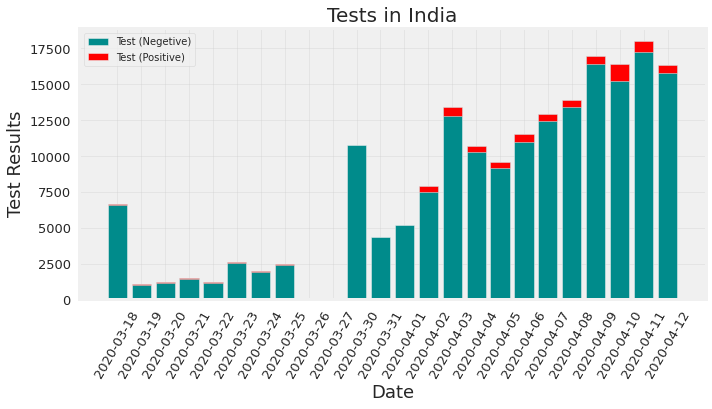

In [292]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.bar(df_india_test["day"],df_india_test["tests"].values[:],color="darkcyan",label="Test (Negetive)"+str())
plt.bar(df_india_test["day"],df_india_test["positive"].values[:],bottom=df_india_test["tests"].values[:]-df_india_test["positive"].values[:],color="Red",label="Test (Positive)")
plt.tick_params(size=5,labelsize = 13)
plt.tick_params(axis="x",size=5,labelsize = 13,labelrotation=60 )
plt.xlabel("Date",fontsize=18)
plt.ylabel("Test Results",fontsize=18)

plt.title("Tests in India",fontsize=20)
plt.grid(alpha=0.3)
plt.legend()

In [293]:
india_data_json = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/statewise').json()
df_india = pd.io.json.json_normalize(india_data_json['data']['statewise'])
df_india = df_india.set_index("state")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [295]:
total = df_india.sum()
total.name = "Total"
pd.DataFrame(total).transpose().style.background_gradient(cmap='Wistia',axis=1)

,confirmed,recovered,deaths,active
Total,9211,1086,331,7794


In [296]:
df_india.style.background_gradient(cmap='Wistia')

,confirmed,recovered,deaths,active
state,,,,
Maharashtra,1982,217,149,1616
Delhi,1154,28,24,1102
Tamil Nadu,1075,50,11,1014
Rajasthan,804,121,11,672
Madhya Pradesh,562,41,43,478
Telangana,531,103,16,412
Gujarat,516,44,24,448
Uttar Pradesh,483,45,5,433
Andhra Pradesh,420,12,7,401


In [297]:
df_india[df_india['deaths'] > 0].style.background_gradient(cmap='Wistia')

,confirmed,recovered,deaths,active
state,,,,
Maharashtra,1982,217,149,1616
Delhi,1154,28,24,1102
Tamil Nadu,1075,50,11,1014
Rajasthan,804,121,11,672
Madhya Pradesh,562,41,43,478
Telangana,531,103,16,412
Gujarat,516,44,24,448
Uttar Pradesh,483,45,5,433
Andhra Pradesh,420,12,7,401


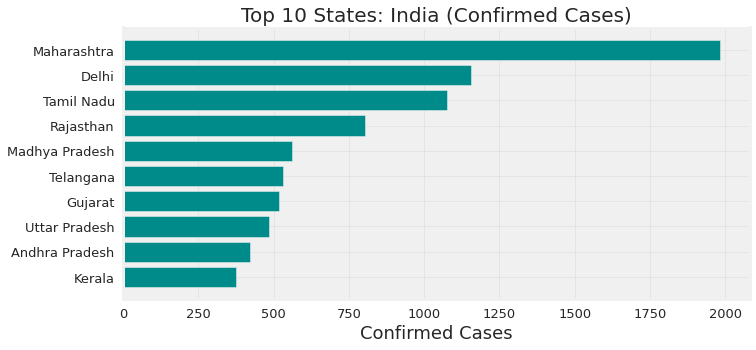

In [298]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_india.sort_values('confirmed')["confirmed"].index[-10:],df_india.sort_values('confirmed')["confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 States: India (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)
#plt.savefig(out+'Top 10 States_India (Confirmed Cases).png')

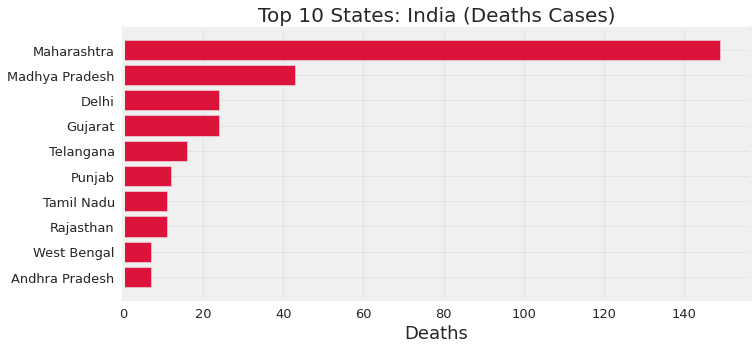

In [299]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_india.sort_values('deaths')["deaths"].index[-10:],df_india.sort_values('deaths')["deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths",fontsize=18)
plt.title("Top 10 States: India (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3)
#plt.savefig(out+'Top 10 States_India (Deaths Cases).png')

## Merging Data (States, Hospitals, Police officers, Population, Gener Ratio):

In [15]:
police = pd.read_excel('/content/datafile.xls')

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [0]:
merged_df = population.merge(police, how = 'inner', right_on='State/UT', left_on='State / Union Territory')
merged_df.drop(['Sno','State / Union Territory','Sl.No'], axis = 1, inplace=True)

In [0]:
merged_df = merged_df.fillna(0)

In [0]:
merged_df['Total Police'] = merged_df['Sanctioned strength of Police Personnel']

In [0]:
cols = ['Total Police per lakh of population - Sanctioned','Total Police per lakh of population - Actual','Sanctioned strength of Police Personnel','onsetEstimate','Gender Ratio']

In [0]:
state_features = merged_df

In [305]:
india_data_unofficial = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org').json()
raw_patient_data = pd.io.json.json_normalize(india_data_unofficial['data']['rawPatientData'])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [0]:
raw_patient_data = raw_patient_data.drop(['contractedFrom','nationality','place_attributes','relationship','travel'], axis = 1)

In [307]:
hospitals_unofficial = requests.get('https://api.rootnet.in/covid19-in/stats/hospitals').json()
hospital_data = pd.io.json.json_normalize(hospitals_unofficial['data']['regional'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [0]:
hospital_data['state'] = hospital_data['state'].str.replace('&', 'and')

In [0]:
merged_df_individual = merged_df.merge(raw_patient_data, how = 'inner', left_on='State/UT', right_on='state')

merged_df_individual = merged_df_individual.merge(hospital_data, how = 'inner', left_on = 'State/UT', right_on='state')

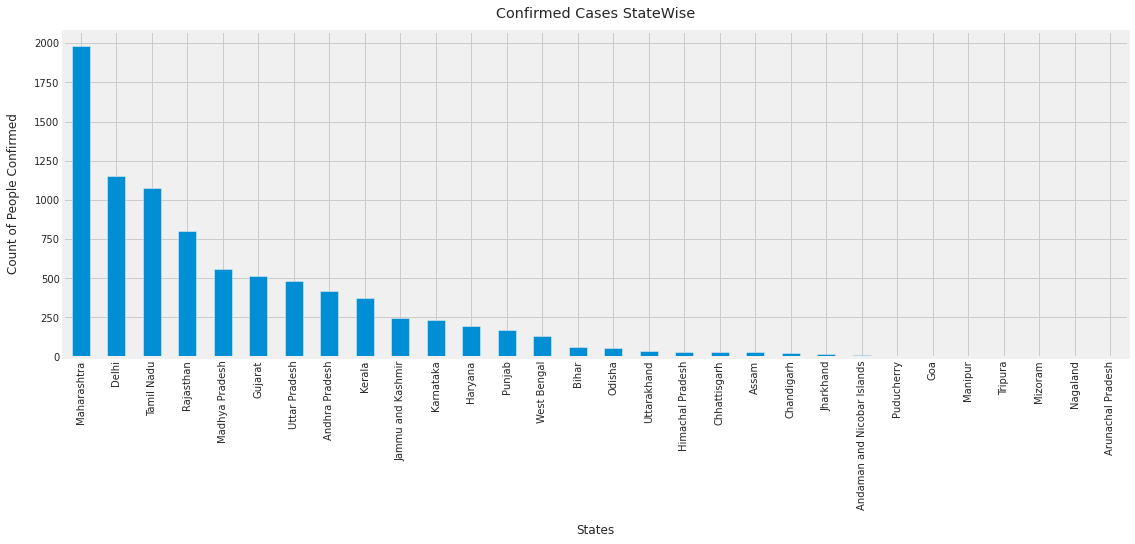

In [310]:
merged_df_individual['State/UT'].value_counts().plot(kind='bar', figsize=(17, 6))
plt.xlabel("States", labelpad=14)
plt.ylabel("Count of People Confirmed", labelpad=14)
plt.title("Confirmed Cases StateWise", y=1.02)
plt.show()

In [0]:
merged_df_individual.drop(cols, axis =1 , inplace=True)

In [0]:
merged_df_individual.drop(['asOn','notes','state_x','state_y'], axis=1, inplace=True)


[(0.0, 100.8)]

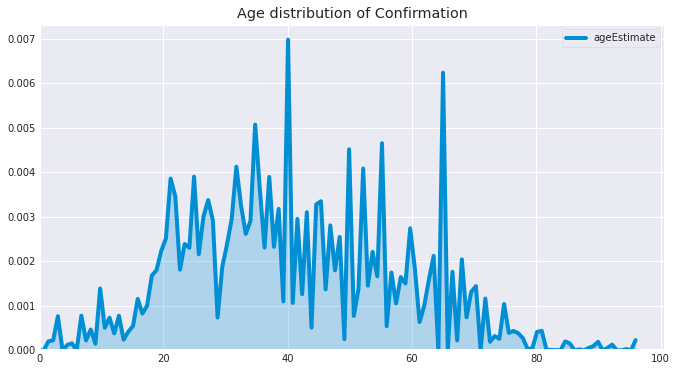

In [313]:
merged_df_individual['ageEstimate'].fillna(0)
merged_df_individual['ageEstimate'] = merged_df_individual['ageEstimate'].replace('28-35','30')
merged_df_individual['ageEstimate'] = merged_df_individual['ageEstimate'].replace('','0')
#merged_df_individual['ageEstimate'].astype(int)
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of Confirmation")
sns.kdeplot(data=merged_df_individual['ageEstimate'].astype(float), shade=True).set(xlim=(0))

In [0]:
merged_df_individual['reportedOn'] = pd.to_datetime(merged_df_individual['reportedOn'], dayfirst=True)

In [0]:
merged_df_individual = merged_df_individual.sort_values(by='reportedOn')

In [0]:
state_features = state_features.merge(hospital_data, how = 'inner', left_on='State/UT', right_on='state')

In [317]:
statewise_unofficial = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/statewise/history').json()
statewise_patient_data = pd.io.json.json_normalize(statewise_unofficial['data']['history'])




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [0]:
cols_date_state = statewise_patient_data['day'],statewise_patient_data['statewise']
date_state = pd.DataFrame(cols_date_state)

In [319]:
date_state = date_state.T
date_state

,day,statewise
0,2020-03-14,"[{'state': 'Kerala', 'confirmed': 19, 'recover..."
1,2020-03-15,"[{'state': 'Maharashtra', 'confirmed': 31, 're..."
2,2020-03-16,"[{'state': 'Maharashtra', 'confirmed': 38, 're..."
3,2020-03-17,"[{'state': 'Maharashtra', 'confirmed': 41, 're..."
4,2020-03-18,"[{'state': 'Maharashtra', 'confirmed': 43, 're..."
5,2020-03-19,"[{'state': 'Maharashtra', 'confirmed': 49, 're..."
6,2020-03-20,"[{'state': 'Maharashtra', 'confirmed': 52, 're..."
7,2020-03-21,"[{'state': 'Maharashtra', 'confirmed': 64, 're..."
8,2020-03-22,"[{'state': 'Maharashtra', 'confirmed': 74, 're..."
9,2020-03-23,"[{'state': 'Maharashtra', 'confirmed': 97, 're..."


In [0]:
date_state['state'] = date_state['statewise'].to_dict()

In [321]:
output = pd.DataFrame()
j = 0
for i in range(1,len(date_state['day'])):  
  output = output.append(date_state['statewise'][i], ignore_index= False)
print(output.head())

           state  confirmed  recovered  deaths  active
0    Maharashtra         31          0       0      31
1         Kerala         24          3       0      21
2        Haryana         14          0       0      14
3  Uttar Pradesh         12          4       0       8
4          Delhi          7          2       1       4


In [0]:
output.reset_index(inplace=True)

In [0]:
output['diff'] = output['index'].diff()

In [325]:
output

,index,state,confirmed,recovered,deaths,active,diff
0,0,Maharashtra,31,0,0,31,NaN
1,1,Kerala,24,3,0,21,1.0
2,2,Haryana,14,0,0,14,1.0
3,3,Uttar Pradesh,12,4,0,8,1.0
4,4,Delhi,7,2,1,4,1.0
...,...,...,...,...,...,...,...
1052,32,Nagaland,1,0,0,1,1.0
1053,33,Daman and Diu,0,0,0,0,1.0
1054,34,Lakshadweep,0,0,0,0,1.0
1055,35,Meghalaya,0,0,0,0,1.0


In [0]:
output['day'] = [0]*len(output)

In [327]:
j=0
for i,v in output.iterrows():
  output['day'][i] = date_state['day'][j]
  if output['diff'][i] <= 0:
    j += 1
    output['day'][i] = date_state['day'][j]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [0]:
date_time_final = output
date_time_final['day'] = pd.to_datetime(date_time_final['day'], dayfirst=True)

In [329]:
date_time_final

,index,state,confirmed,recovered,deaths,active,diff,day
0,0,Maharashtra,31,0,0,31,NaN,2020-03-14
1,1,Kerala,24,3,0,21,1.0,2020-03-14
2,2,Haryana,14,0,0,14,1.0,2020-03-14
3,3,Uttar Pradesh,12,4,0,8,1.0,2020-03-14
4,4,Delhi,7,2,1,4,1.0,2020-03-14
...,...,...,...,...,...,...,...,...
1052,32,Nagaland,1,0,0,1,1.0,2020-04-11
1053,33,Daman and Diu,0,0,0,0,1.0,2020-04-11
1054,34,Lakshadweep,0,0,0,0,1.0,2020-04-11
1055,35,Meghalaya,0,0,0,0,1.0,2020-04-11


In [0]:
date_time_final_try = date_time_final.merge(state_features, how = 'left', left_on='state', right_on='State/UT')

In [331]:
date_time_final_try

,index,state_x,confirmed,recovered,deaths,active,diff,day,Population,Rural population,Urban population,Area,Density,Gender Ratio,State/UT,Total Police per lakh of population - Sanctioned,Total Police per lakh of population - Actual,Sanctioned strength of Police Personnel,Total Police,state_y,ruralHospitals,ruralBeds,urbanHospitals,urbanBeds,totalHospitals,totalBeds,asOn
0,0,Maharashtra,31,0,0,31,NaN,2020-03-14,112374333.0,61556074.0,50818259.0,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929.0,Maharashtra,198.7,186.5,220126.0,220126.0,Maharashtra,273.0,12398.0,438.0,39048.0,711.0,51446.0,2015-12-31T00:00:00.000Z
1,1,Kerala,24,3,0,21,1.0,2020-03-14,33406061.0,17471135.0,15934926.0,"38,863 km2 (15,005 sq mi)","859/km2 (2,220/sq mi)",1084.0,Kerala,178.2,174.5,53998.0,53998.0,Kerala,981.0,16865.0,299.0,21139.0,1280.0,38004.0,2017-01-01T00:00:00.000Z
2,2,Haryana,14,0,0,14,1.0,2020-03-14,25351462.0,16509359.0,8842103.0,"44,212 km2 (17,070 sq mi)","573/km2 (1,480/sq mi)",879.0,Haryana,230.0,164.8,59044.0,59044.0,Haryana,609.0,6690.0,59.0,4550.0,668.0,11240.0,2016-12-31T00:00:00.000Z
3,3,Uttar Pradesh,12,4,0,8,1.0,2020-03-14,199812341.0,155317278.0,44495063.0,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912.0,Uttar Pradesh,187.8,90.4,377009.0,377009.0,Uttar Pradesh,4442.0,39104.0,193.0,37156.0,4635.0,76260.0,2017-12-31T00:00:00.000Z
4,4,Delhi,7,2,1,4,1.0,2020-03-14,16787941.0,419042.0,16368899.0,"1,484 km2 (573 sq mi)","11,297/km2 (29,260/sq mi)",868.0,Delhi,390.0,383.3,75207.0,75207.0,Delhi,0.0,0.0,109.0,24383.0,109.0,24383.0,2015-01-01T00:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,32,Nagaland,1,0,0,1,1.0,2020-04-11,1978502.0,1407536.0,570966.0,"16,579 km2 (6,401 sq mi)",119/km2 (310/sq mi),931.0,Nagaland,900.8,965.8,9086.0,9086.0,Nagaland,21.0,630.0,15.0,1250.0,36.0,1880.0,2015-12-31T00:00:00.000Z
1053,33,Daman and Diu,0,0,0,0,1.0,2020-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1054,34,Lakshadweep,0,0,0,0,1.0,2020-04-11,64473.0,14141.0,50332.0,32 km2 (12 sq mi),"2,013/km2 (5,210/sq mi)",946.0,Lakshadweep,685.4,492.7,562.0,562.0,Lakshadweep,9.0,300.0,0.0,0.0,9.0,300.0,2016-01-01T00:00:00.000Z
1055,35,Meghalaya,0,0,0,0,1.0,2020-04-11,2966889.0,2371439.0,595450.0,"22,429 km2 (8,660 sq mi)",132/km2 (340/sq mi),989.0,Meghalaya,549.2,442.7,7840.0,7840.0,Meghalaya,143.0,1970.0,14.0,2487.0,157.0,4457.0,2017-12-31T00:00:00.000Z


In [0]:
date_time_final_try['confirm_time_diff_statewise'] = date_time_final_try.groupby(['state_x'])['confirmed'].diff().fillna(date_time_final_try['confirmed'])
date_time_final_try['death_time_diff_statewise'] = date_time_final_try.groupby(['state_x'])['deaths'].diff().fillna(date_time_final_try['deaths'])

In [333]:
date_time_final_try['confirm_time_diff_statewise'].sum()

9211.0

In [0]:
date_time_final_try = date_time_final_try.fillna(0)

In [335]:
date_time_final_try[date_time_final_try['State/UT'] == 'Rajasthan']['confirm_time_diff_statewise'].sum()

804.0

In [0]:
cols_final_drop = ['index','state_x','active','diff','Total Police per lakh of population - Sanctioned','Total Police per lakh of population - Actual','Sanctioned strength of Police Personnel','state_y']
date_time_final_try.drop(cols_final_drop, inplace=True, axis = 1)

In [0]:
date_time_final_try['Area'] = date_time_final_try['Area'].str.split(n=1).str[0]
date_time_final_try['Area'] = date_time_final_try['Area'].str.replace(',','')
date_time_final_try['Density'] = date_time_final_try['Density'].str.split(n=1).str[0]
date_time_final_try['Density'] = date_time_final_try['Density'].str.replace(',','')



In [0]:
date_time_final_try['Density'] = date_time_final_try['Density'].str.split('/').str[0]


In [0]:
date_time_final_try.fillna(0, inplace=True)

In [340]:
date_time_final_try['Area'] = date_time_final_try['Area'].astype(int)
date_time_final_try['Density'] = date_time_final_try['Density'].astype(int)

date_time_final_try.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1057 entries, 0 to 1056
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   confirmed                    1057 non-null   int64         
 1   recovered                    1057 non-null   int64         
 2   deaths                       1057 non-null   int64         
 3   day                          1057 non-null   datetime64[ns]
 4   Population                   1057 non-null   float64       
 5   Rural population             1057 non-null   float64       
 6   Urban population             1057 non-null   float64       
 7   Area                         1057 non-null   int64         
 8   Density                      1057 non-null   int64         
 9   Gender Ratio                 1057 non-null   float64       
 10  State/UT                     1057 non-null   object        
 11  Total Police                 1057 non-null 

In [0]:
date = '2020-03-14'
date = datetime.strptime(date, '%Y-%m-%d')

date_time_final_try['Day'] = date_time_final_try['day'] - date

In [0]:
date_time_final_try['Day'] = date_time_final_try['Day'].astype(str).str.split( ' ').str[0]
date_time_final_try['Day'] = date_time_final_try['Day'].astype(int)

In [0]:
date_time_final_try = date_time_final_try[['Population','Rural population',	'Urban population',	'Area',	'Density','Gender Ratio'	,'State/UT',	'Total Police','ruralHospitals','ruralBeds','urbanHospitals','urbanBeds','Day','confirmed','deaths']]

In [0]:
date_time_final_try.sort_values(by='Day', inplace=True)
date_time_final_try.reset_index(inplace=True)
date_time_final_try.fillna(0, inplace= True)

## Predicting cases and deaths in India using all the statistics



In [0]:
X = date_time_final_try.iloc[:,:-2]
Y_death = date_time_final_try.iloc[:,-1]
Y = date_time_final_try.iloc[:,-2]
X['State/UT'] = X['State/UT'].astype(str)

In [0]:
from sklearn.preprocessing import OneHotEncoder
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(X[['State/UT']]).toarray())
# merge with main df bridge_df on key values
X = X.join(enc_df)

In [0]:
X.drop(['State/UT','index'], inplace=True, axis = 1)

In [351]:
X

,Population,Rural population,Urban population,Area,Density,Gender Ratio,Total Police,ruralHospitals,ruralBeds,urbanHospitals,urbanBeds,Day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,112374333.0,61556074.0,50818259.0,307713,365,929.0,220126.0,273.0,12398.0,438.0,39048.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3673917.0,2712464.0,961453.0,10486,350,960.0,12537.0,99.0,1140.0,56.0,3277.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,91276115.0,62183113.0,29093002.0,88752,1029,953.0,107777.0,1272.0,19684.0,294.0,58882.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1458545.0,551731.0,906814.0,3702,394,973.0,5630.0,17.0,1405.0,25.0,1608.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1383727.0,1066358.0,317369.0,83743,17,938.0,8538.0,208.0,2136.0,10.0,268.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,27743338.0,17344192.0,10399146.0,50362,550,895.0,68902.0,510.0,5805.0,172.0,12128.0,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1053,91276115.0,62183113.0,29093002.0,88752,1029,953.0,107777.0,1272.0,19684.0,294.0,58882.0,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1054,104099452.0,92341436.0,11758016.0,94163,1102,918.0,92422.0,930.0,6083.0,103.0,5936.0,28,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1055,199812341.0,155317278.0,44495063.0,240928,828,912.0,377009.0,4442.0,39104.0,193.0,37156.0,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , Y
                                                    , test_size=0.1
                                                    , shuffle=False) 

X_train_death, X_test_death, y_train_death, y_test_death = train_test_split(X
                                                    , Y_death
                                                    , test_size=0.1
                                                    , shuffle=False
                                                    , random_state = 42) 

In [0]:
y_test = y_test.reset_index(drop = True)
y_test_death = y_test_death.reset_index(drop=True)

In [0]:
X_test = X_test.reset_index(drop = True)


In [0]:
X_test = X_test[X_test['Population'] == 49577103.0]
y_test = date_time_final_try['confirmed'].iloc[X_test.index]

In [0]:
poly = PolynomialFeatures(degree= 4)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)


# Transform our death data for polynomial regression
poly_death = PolynomialFeatures(degree= 4)
poly_X_train_death = poly_death.fit_transform(X_train_death)
poly_X_test_death = poly_death.fit_transform(X_test_death)


In [364]:
# polynomial regression cases
linear_model = LinearRegression()
linear_model.fit(poly_X_train, y_train)
test_linear_pred = linear_model.predict(poly_X_test)


# evaluating with MAE and MSE
print('MAE:', mean_absolute_error(test_linear_pred, y_test))
print('MSE:',mean_squared_error(test_linear_pred, y_test))

MAE: 142.1817589889108
MSE: 52873.184687062814


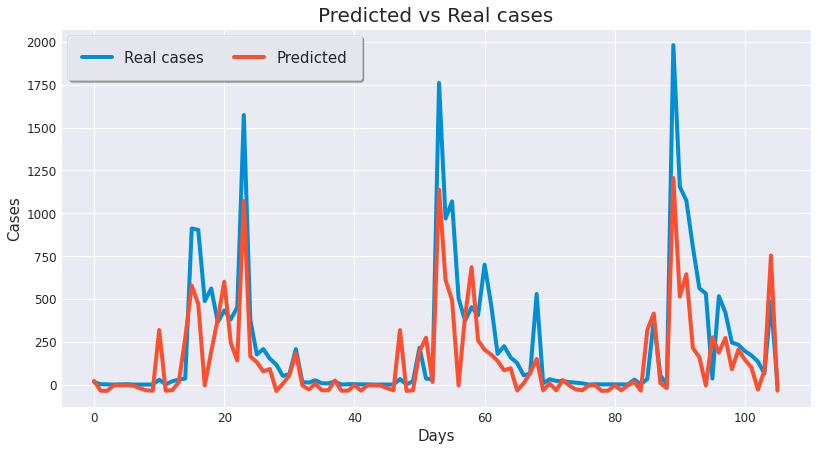

In [365]:
plt.figure(figsize=(12,7))

plt.plot(y_test, label = "Real cases")
plt.plot(test_linear_pred, label = "Predicted")
plt.title("Predicted vs Real cases", size = 20)
plt.xlabel('Days', size = 15)
plt.ylabel('Cases', size = 15)
plt.xticks(size=12)
plt.yticks(size=12)

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15});

In [368]:
linear_model_death = LinearRegression(fit_intercept=False)
linear_model_death.fit(poly_X_train_death, y_train_death)
test_linear_pred_death = linear_model_death.predict(poly_X_test_death)

# evaluating with MAE and MSE
print('MAE:', mean_absolute_error(test_linear_pred_death, y_test_death))
print('MSE:',mean_squared_error(test_linear_pred_death, y_test_death))

MAE: 5.835305523828821
MSE: 168.76949582190258


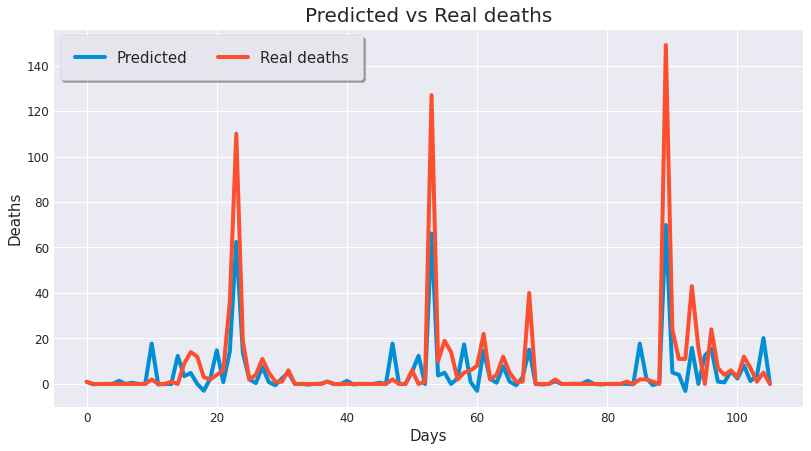

In [369]:
plt.figure(figsize=(12,7))

plt.plot(test_linear_pred_death, label = "Predicted")
plt.plot(y_test_death, label = "Real deaths")
plt.title("Predicted vs Real deaths", size = 20)
plt.xlabel('Days', size = 15)
plt.ylabel('Deaths', size = 15)
plt.xticks(size=12)
plt.yticks(size=12)

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15});


## Predicting Cases and Deaths in Maharashtra using only the number of cases and deaths per day

In [0]:
X = date_time_final_try.iloc[:,:-2]
Y_death = date_time_final_try.iloc[:,-1]
Y = date_time_final_try.iloc[:,-2]

In [0]:
date_time_final_try_m = date_time_final_try[date_time_final_try['State/UT'] == 'Maharashtra']

In [0]:
cases_m = date_time_final_try_m['confirmed'].groupby(date_time_final_try['Day']).sum().sort_values(ascending=True)
deaths_m = date_time_final_try_m['deaths'].groupby(date_time_final_try['Day']).sum().sort_values(ascending=True)
maharasthra_cases = np.array(cases_m).reshape(-1, 1)

maharashtra_deaths = np.array(deaths_m).reshape(-1, 1)
days_since_first_case_m = np.array([i for i in range(len(cases_m.index))]).reshape(-1, 1)
days_since_first_death_m = np.array([i for i in range(len(deaths_m.index))]).reshape(-1, 1)

days_in_future = 15
future_forcast_m = np.array([i for i in range(len(cases_m.index)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast_m[:-15]
future_forcast_deaths_m = np.array([i for i in range(len(deaths_m.index)+days_in_future)]).reshape(-1, 1)
adjusted_dates_deaths = future_forcast_deaths_m[:-15]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(days_since_first_case_m
                                                    , maharasthra_cases
                                                    , test_size=0.30
                                                    , shuffle=False) 

X_train_death, X_test_death, y_train_death, y_test_death = train_test_split(days_since_first_death_m
                                                    , maharashtra_deaths
                                                    , test_size=0.3
                                                    , shuffle=False
                                                    , random_state = 42) 

In [0]:
poly = PolynomialFeatures(degree= 4)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)
poly_future_forcast = poly.fit_transform(future_forcast_m)

# Transform our death data for polynomial regression
poly_death = PolynomialFeatures(degree= 4)
poly_X_train_death = poly_death.fit_transform(X_train_death)
poly_X_test_death = poly_death.fit_transform(X_test_death)
poly_future_forcast_death = poly_death.fit_transform(future_forcast_deaths_m)

In [375]:
# polynomial regression cases
linear_model = LinearRegression()
linear_model.fit(poly_X_train, y_train)
test_linear_pred = linear_model.predict(poly_X_test)
linear_pred = linear_model.predict(poly_future_forcast)

# evaluating with MAE and MSE
print('MAE:', mean_absolute_error(test_linear_pred, y_test))
print('MSE:',mean_squared_error(test_linear_pred, y_test))

MAE: 93.74065935496594
MSE: 17646.22555561457


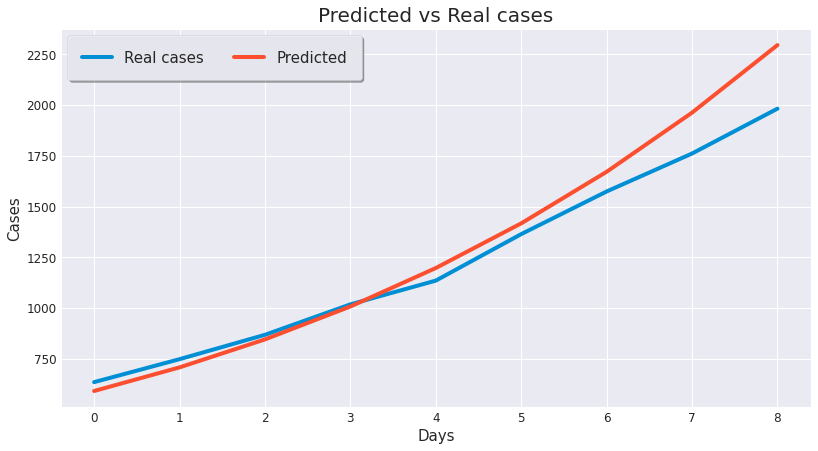

In [376]:
plt.figure(figsize=(12,7))

plt.plot(y_test, label = "Real cases")
plt.plot(test_linear_pred, label = "Predicted")
plt.title("Predicted vs Real cases", size = 20)
plt.xlabel('Days', size = 15)
plt.ylabel('Cases', size = 15)
plt.xticks(size=12)
plt.yticks(size=12)

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15});

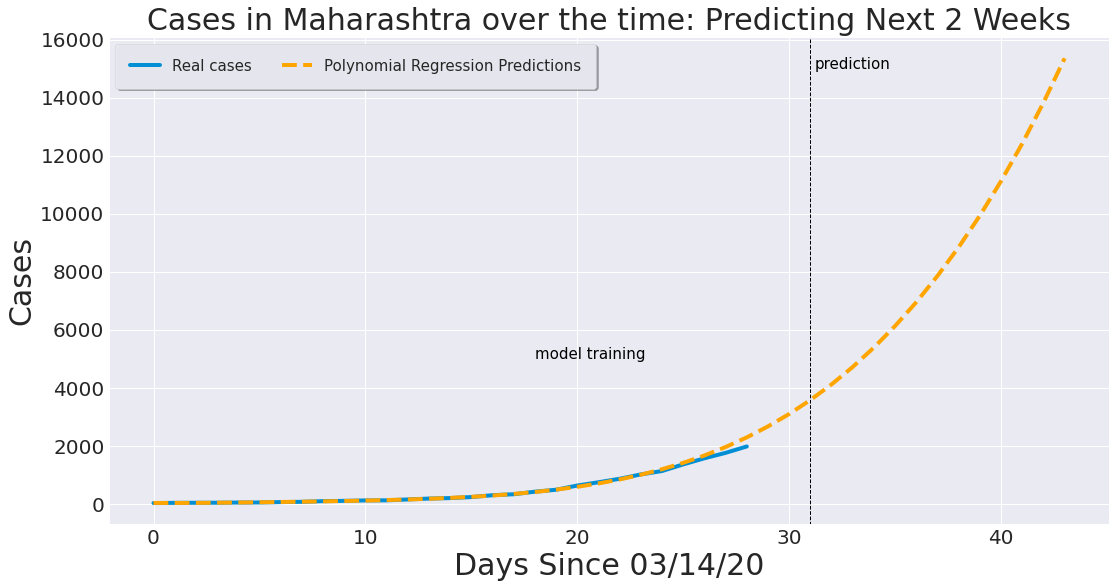

In [377]:
plt.figure(figsize=(16, 9))

plt.plot(adjusted_dates
         , maharasthra_cases
         , label = "Real cases")

plt.plot(future_forcast_m
         , linear_pred
         , label = "Polynomial Regression Predictions"
         , linestyle='dashed'
         , color='orange')

plt.title('Cases in Maharashtra over the time: Predicting Next 2 Weeks', size=30)
plt.xlabel('Days Since 03/14/20', size=30)
plt.ylabel('Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)

plt.axvline(31, color='black'
            , linestyle="--"
            , linewidth=1)

plt.text(18, 5000
         , "model training"
         , size = 15
         , color = "black")

plt.text(31.2, 15000
         , "prediction"
         , size = 15
         , color = "black")

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15})

plt.show();

In [378]:
linear_model_death = LinearRegression(fit_intercept=False)
linear_model_death.fit(poly_X_train_death, y_train_death)
test_linear_pred_death = linear_model_death.predict(poly_X_test_death)
linear_pred_death = linear_model_death.predict(poly_future_forcast_death)

# evaluating with MAE and MSE
print('MAE:', mean_absolute_error(test_linear_pred_death, y_test_death))
print('MSE:',mean_squared_error(test_linear_pred_death, y_test_death))

MAE: 4.312663698953685
MSE: 32.603175641518675


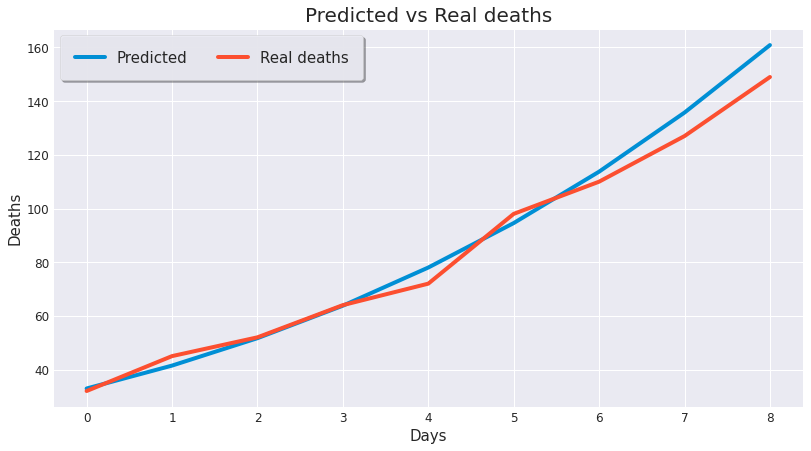

In [379]:
plt.figure(figsize=(12,7))

plt.plot(test_linear_pred_death, label = "Predicted")
plt.plot(y_test_death, label = "Real deaths")
plt.title("Predicted vs Real deaths", size = 20)
plt.xlabel('Days', size = 15)
plt.ylabel('Deaths', size = 15)
plt.xticks(size=12)
plt.yticks(size=12)

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15});


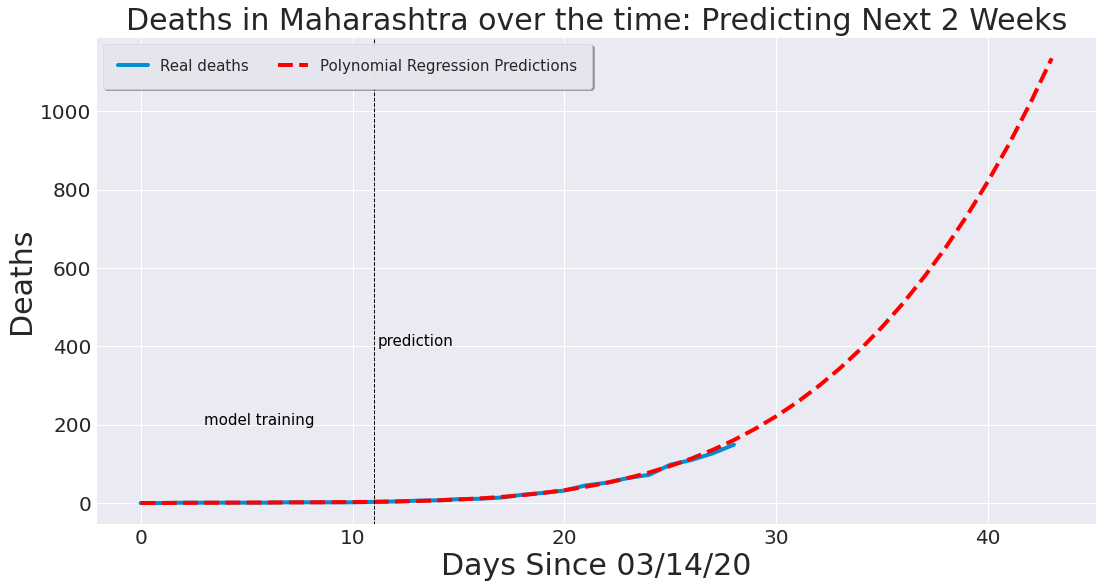

In [384]:
plt.figure(figsize=(16, 9))

plt.plot(adjusted_dates_deaths
         , maharashtra_deaths
         , label = "Real deaths")

plt.plot(future_forcast_deaths_m
         , linear_pred_death
         , label = "Polynomial Regression Predictions"
         , linestyle='dashed'
         , color='red')

plt.title('Deaths in Maharashtra over the time: Predicting Next 2 Weeks', size=30)
plt.xlabel('Days Since 03/14/20', size=30)
plt.ylabel('Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)

plt.axvline(11, color='black'
            , linestyle="--"
            , linewidth=1)

plt.text(3, 200
         , "model training"
         , size = 15
         , color = "black")

plt.text(11.2, 400
         , "prediction"
         , size = 15
         , color = "black")

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15})

plt.show();

## Predicting Cases and Deaths in **India** using only the number of cases and deaths per day

In [0]:
cases = date_time_final_try['confirmed'].groupby(date_time_final_try['Day']).sum().sort_values(ascending=True)

In [0]:
deaths =  date_time_final_try['deaths'].groupby(date_time_final_try['Day']).sum().sort_values(ascending=True)
India_cases = np.array(cases).reshape(-1, 1)

India_deaths = np.array(deaths).reshape(-1, 1)
days_since_first_case = np.array([i for i in range(len(cases.index))]).reshape(-1, 1)
days_since_first_death = np.array([i for i in range(len(deaths.index))]).reshape(-1, 1)

days_in_future = 15
future_forcast = np.array([i for i in range(len(cases.index)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-15]
future_forcast_deaths = np.array([i for i in range(len(deaths.index)+days_in_future)]).reshape(-1, 1)
adjusted_dates_deaths = future_forcast_deaths[:-15]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(days_since_first_case
                                                    , India_cases
                                                    , test_size=0.15
                                                    , shuffle=False) 

X_train_death, X_test_death, y_train_death, y_test_death = train_test_split(days_since_first_death
                                                    , India_deaths
                                                    , test_size=0.15
                                                    , shuffle=False
                                                    , random_state = 42) 

In [0]:
poly = PolynomialFeatures(degree= 4)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)
poly_future_forcast = poly.fit_transform(future_forcast)

# Transform our death data for polynomial regression
poly_death = PolynomialFeatures(degree= 4)
poly_X_train_death = poly_death.fit_transform(X_train_death)
poly_X_test_death = poly_death.fit_transform(X_test_death)
poly_future_forcast_death = poly_death.fit_transform(future_forcast_deaths)

In [389]:
# polynomial regression cases
linear_model = LinearRegression()
linear_model.fit(poly_X_train, y_train)
test_linear_pred = linear_model.predict(poly_X_test)
linear_pred = linear_model.predict(poly_future_forcast)

# evaluating with MAE and MSE
print('MAE:', mean_absolute_error(test_linear_pred, y_test))
print('MSE:',mean_squared_error(test_linear_pred, y_test))

MAE: 607.1298125673926
MSE: 423154.524667917


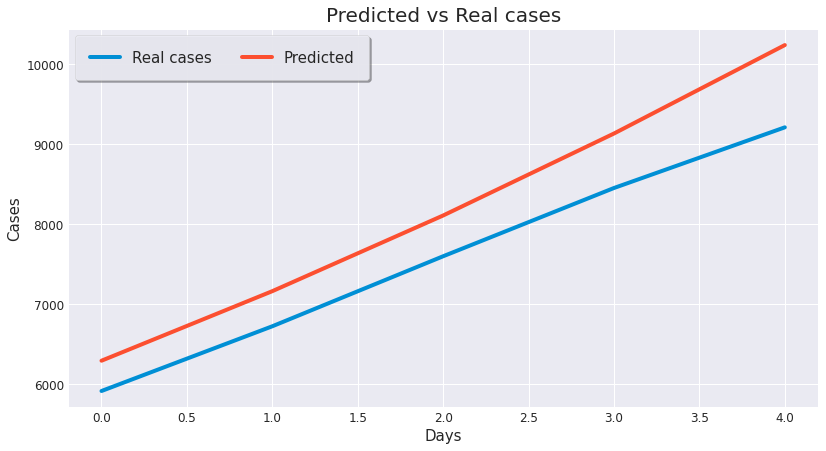

In [390]:
plt.figure(figsize=(12,7))

plt.plot(y_test, label = "Real cases")
plt.plot(test_linear_pred, label = "Predicted")
plt.title("Predicted vs Real cases", size = 20)
plt.xlabel('Days', size = 15)
plt.ylabel('Cases', size = 15)
plt.xticks(size=12)
plt.yticks(size=12)

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15});

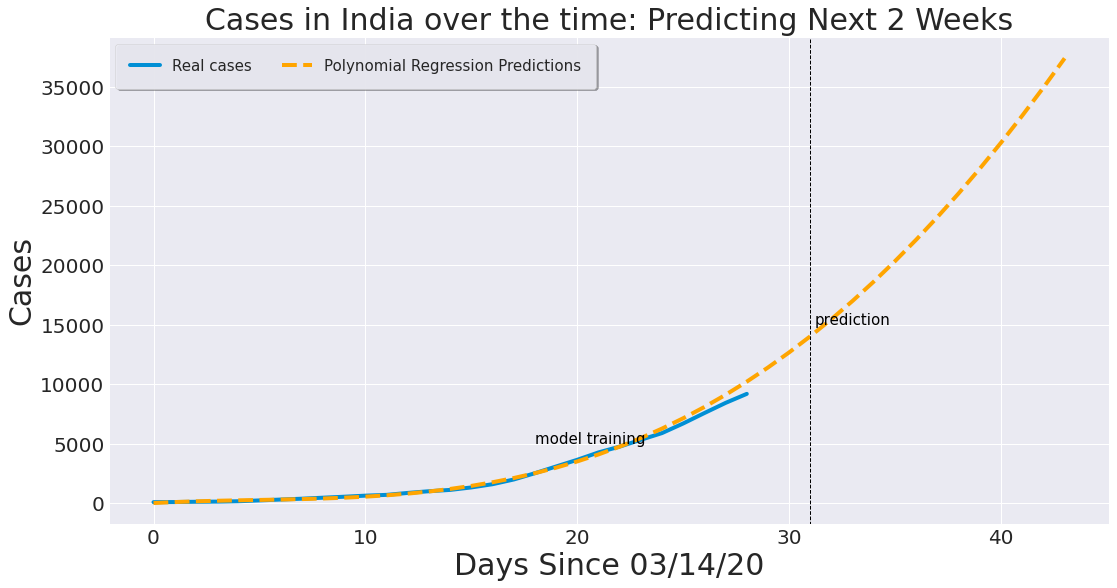

In [391]:
plt.figure(figsize=(16, 9))

plt.plot(adjusted_dates
         , India_cases
         , label = "Real cases")

plt.plot(future_forcast
         , linear_pred
         , label = "Polynomial Regression Predictions"
         , linestyle='dashed'
         , color='orange')

plt.title('Cases in India over the time: Predicting Next 2 Weeks', size=30)
plt.xlabel('Days Since 03/14/20', size=30)
plt.ylabel('Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)

plt.axvline(31, color='black'
            , linestyle="--"
            , linewidth=1)

plt.text(18, 5000
         , "model training"
         , size = 15
         , color = "black")

plt.text(31.2, 15000
         , "prediction"
         , size = 15
         , color = "black")

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15})

plt.show();

In [392]:
linear_model_death = LinearRegression(fit_intercept=False)
linear_model_death.fit(poly_X_train_death, y_train_death)
test_linear_pred_death = linear_model_death.predict(poly_X_test_death)
linear_pred_death = linear_model_death.predict(poly_future_forcast_death)

# evaluating with MAE and MSE
print('MAE:', mean_absolute_error(test_linear_pred_death, y_test_death))
print('MSE:',mean_squared_error(test_linear_pred_death, y_test_death))

MAE: 16.430685843913515
MSE: 351.21935863785046


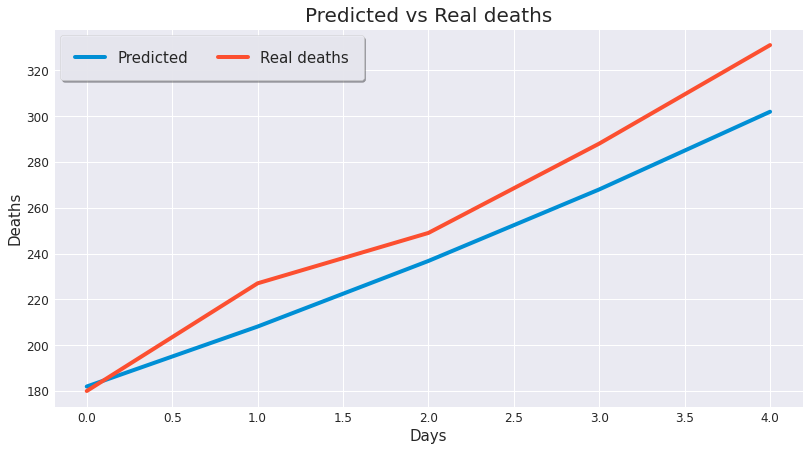

In [393]:
plt.figure(figsize=(12,7))

plt.plot(test_linear_pred_death, label = "Predicted")
plt.plot(y_test_death, label = "Real deaths")
plt.title("Predicted vs Real deaths", size = 20)
plt.xlabel('Days', size = 15)
plt.ylabel('Deaths', size = 15)
plt.xticks(size=12)
plt.yticks(size=12)

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15});


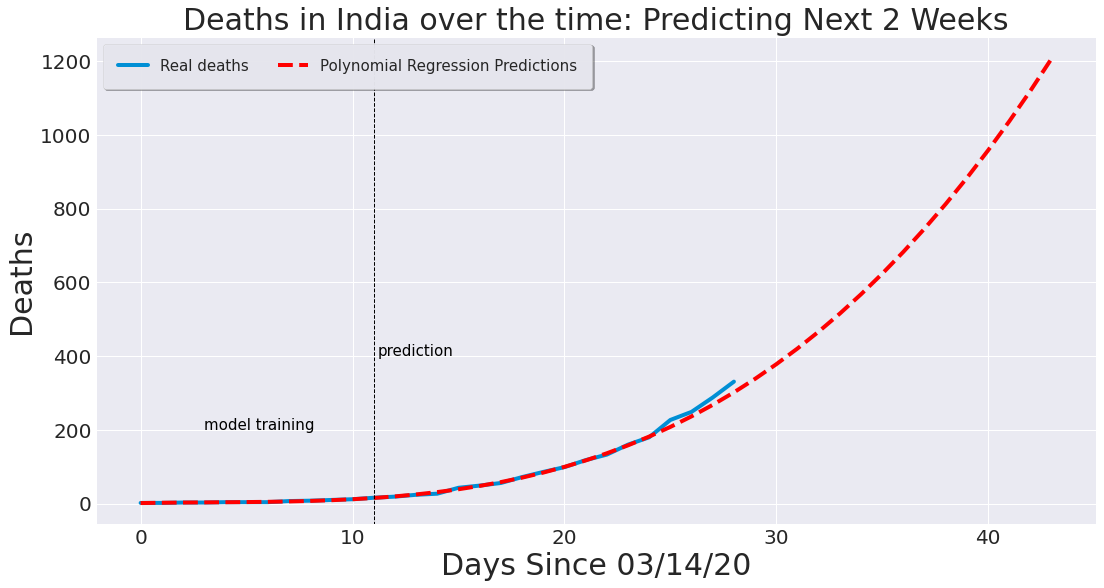

In [394]:
plt.figure(figsize=(16, 9))

plt.plot(adjusted_dates_deaths
         , India_deaths
         , label = "Real deaths")

plt.plot(future_forcast_deaths
         , linear_pred_death
         , label = "Polynomial Regression Predictions"
         , linestyle='dashed'
         , color='red')

plt.title('Deaths in India over the time: Predicting Next 2 Weeks', size=30)
plt.xlabel('Days Since 03/14/20', size=30)
plt.ylabel('Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)

plt.axvline(11, color='black'
            , linestyle="--"
            , linewidth=1)

plt.text(3, 200
         , "model training"
         , size = 15
         , color = "black")

plt.text(11.2, 400
         , "prediction"
         , size = 15
         , color = "black")

# defyning legend config
plt.legend(loc = "upper left"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1
           , prop={'size': 15})

plt.show();